# Quark and Gluon Jets Dataset - Exploratory Data Analysis

This notebook performs basic analysis on the Quark and Gluon Jets dataset from Zenodo.

**Dataset Details:**
- 100,000 jets (50k quark, 50k gluon)
- Generated with Pythia 8.226
- FastJet 3.3.0, anti-kt jets with R=0.4
- $p_T^{\text{jet}} \in [500, 550]$ GeV, $|y^{\text{jet}}| < 1.7$
- Features: pt, rapidity, azimuthal angle, pdgid for each particle

## 1. Import Libraries and Load Dataset

**Note:** The dataset should be downloaded first using the provided script:
```bash
python scripts/download_qg_data.py
```

This will use the [EnergyFlow](https://energyflow.network/) package to download the standard quark-gluon jet tagging benchmark dataset and save it to `data/qg_jets.npz`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Set up data path
data_path = Path("../data/qg_jets.npz")

if not data_path.exists():
    print("Dataset not found. Please run the download script:")
    print("  python scripts/download_qg_data.py")
    print("\nThis will download the dataset using EnergyFlow and save it to data/qg_jets.npz")
    raise FileNotFoundError(f"Dataset not found at {data_path}")
else:
    print(f"Dataset found at {data_path}")
    print(f"File size: {data_path.stat().st_size / (1024**2):.2f} MB")

Dataset found at ../data/qg_jets.npz
File size: 424.96 MB


## 2. Load and Examine the Dataset Structure

In [3]:
# Load the dataset
data = np.load(data_path)

# Examine the structure
print("Keys in the dataset:")
for key in data.keys():
    print(f"  {key}: shape = {data[key].shape}, dtype = {data[key].dtype}")
    
print(f"\nTotal file size: {data_path.stat().st_size / (1024**2):.2f} MB")

Keys in the dataset:
  X: shape = (100000, 139, 4), dtype = float64
  y: shape = (100000,), dtype = float64

Total file size: 424.96 MB
  X: shape = (100000, 139, 4), dtype = float64
  y: shape = (100000,), dtype = float64

Total file size: 424.96 MB


In [4]:
# Extract X (features) and y (labels)
X = data['X']
y = data['y']

print(f"Features (X): shape = {X.shape}")
print(f"  - Number of jets: {X.shape[0]}")
print(f"  - Max particles per jet (M): {X.shape[1]}")
print(f"  - Features per particle: {X.shape[2]}")
print(f"  - Features: [pt, rapidity, azimuthal angle, pdgid]")

print(f"\nLabels (y): shape = {y.shape}")
print(f"  - 0 = gluon jet")
print(f"  - 1 = quark jet")

print(f"\nClass distribution:")
print(f"  Gluon jets (0): {np.sum(y == 0)} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"  Quark jets (1): {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")

Features (X): shape = (100000, 139, 4)
  - Number of jets: 100000
  - Max particles per jet (M): 139
  - Features per particle: 4
  - Features: [pt, rapidity, azimuthal angle, pdgid]

Labels (y): shape = (100000,)
  - 0 = gluon jet
  - 1 = quark jet

Class distribution:
  Gluon jets (0): 50000 (50.0%)
  Quark jets (1): 50000 (50.0%)


## 3. Analyze Jet Multiplicity

Examine how many particles are actually present in each jet (excluding padding).

In [5]:
# Calculate multiplicity (number of non-zero particles per jet)
# A particle is considered padding if its pt is 0
multiplicity = np.sum(X[:, :, 0] > 0, axis=1)

print(f"Multiplicity statistics:")
print(f"  Mean: {np.mean(multiplicity):.2f}")
print(f"  Std: {np.std(multiplicity):.2f}")
print(f"  Min: {np.min(multiplicity)}")
print(f"  Max: {np.max(multiplicity)}")
print(f"  Median: {np.median(multiplicity):.2f}")

# Separate by jet type
mult_gluon = multiplicity[y == 0]
mult_quark = multiplicity[y == 1]

print(f"\nGluon jets:")
print(f"  Mean multiplicity: {np.mean(mult_gluon):.2f} ± {np.std(mult_gluon):.2f}")

print(f"\nQuark jets:")
print(f"  Mean multiplicity: {np.mean(mult_quark):.2f} ± {np.std(mult_quark):.2f}")

Multiplicity statistics:
  Mean: 43.31
  Std: 17.65
  Min: 1
  Max: 139
  Median: 41.00

Gluon jets:
  Mean multiplicity: 53.22 ± 15.76

Quark jets:
  Mean multiplicity: 33.40 ± 13.34


/var/folders/pw/_hqmfg2s6tjg6q8m5gq204gm0000gn/T/ipykernel_30260/3664187074.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=['Quark', 'Gluon'])


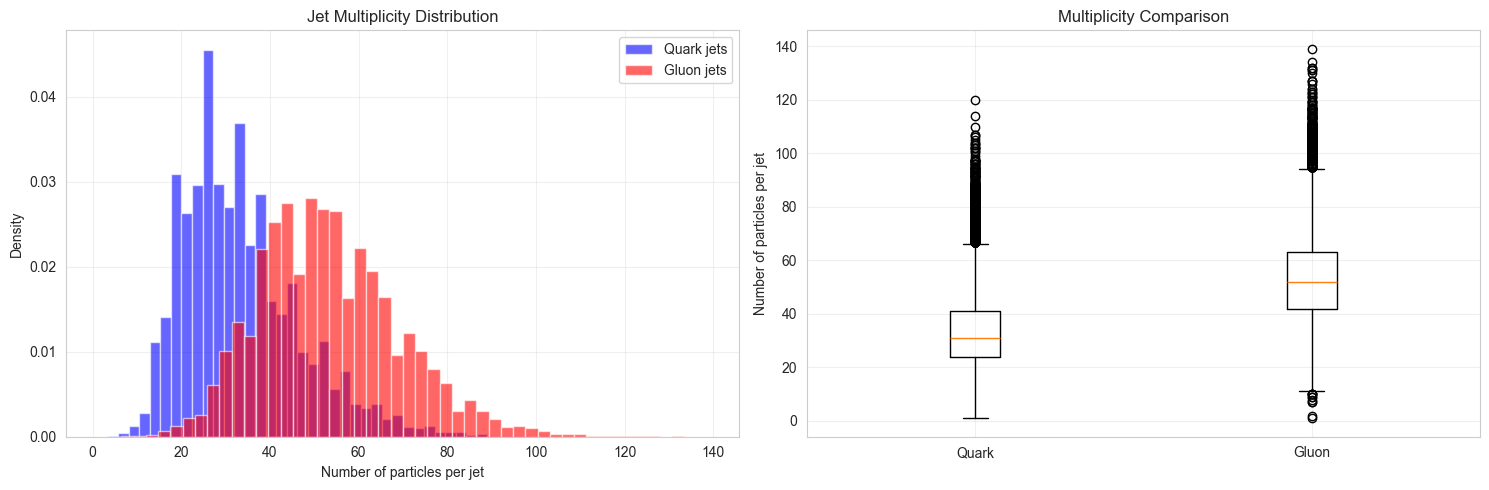

In [6]:
# Plot multiplicity distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram comparing quark and gluon
axes[0].hist(mult_quark, bins=50, alpha=0.6, label='Quark jets', density=True, color='blue')
axes[0].hist(mult_gluon, bins=50, alpha=0.6, label='Gluon jets', density=True, color='red')
axes[0].set_xlabel('Number of particles per jet')
axes[0].set_ylabel('Density')
axes[0].set_title('Jet Multiplicity Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [mult_quark, mult_gluon]
axes[1].boxplot(data_to_plot, labels=['Quark', 'Gluon'])
axes[1].set_ylabel('Number of particles per jet')
axes[1].set_title('Multiplicity Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Analyze Particle Features

Examine the distribution of pt, rapidity, azimuthal angle, and pdgid.

In [7]:
# Extract features (excluding padding)
# Get mask for non-zero particles
mask = X[:, :, 0] > 0

# Flatten and extract non-padded values
pt_all = X[:, :, 0][mask]
rapidity_all = X[:, :, 1][mask]
phi_all = X[:, :, 2][mask]
pdgid_all = X[:, :, 3][mask]

print("Feature statistics (all non-padded particles):")
print(f"\npt:")
print(f"  Range: [{np.min(pt_all):.4f}, {np.max(pt_all):.4f}]")
print(f"  Mean: {np.mean(pt_all):.4f} ± {np.std(pt_all):.4f}")

print(f"\nRapidity:")
print(f"  Range: [{np.min(rapidity_all):.4f}, {np.max(rapidity_all):.4f}]")
print(f"  Mean: {np.mean(rapidity_all):.4f} ± {np.std(rapidity_all):.4f}")

print(f"\nAzimuthal angle:")
print(f"  Range: [{np.min(phi_all):.4f}, {np.max(phi_all):.4f}]")
print(f"  Mean: {np.mean(phi_all):.4f} ± {np.std(phi_all):.4f}")

print(f"\npdgid:")
print(f"  Unique values: {len(np.unique(pdgid_all))}")
print(f"  Most common pdgids:")
unique, counts = np.unique(pdgid_all, return_counts=True)
top_indices = np.argsort(counts)[-10:][::-1]
for idx in top_indices:
    print(f"    {int(unique[idx])}: {counts[idx]} ({counts[idx]/len(pdgid_all)*100:.2f}%)")

Feature statistics (all non-padded particles):

pt:
  Range: [0.0001, 548.4937]
  Mean: 12.0958 ± 24.7145

Rapidity:
  Range: [-2.1281, 2.2004]
  Mean: 0.0027 ± 0.8780

Azimuthal angle:
  Range: [-0.4199, 6.7172]
  Mean: 3.1374 ± 1.8208

pdgid:
  Unique values: 14
  Most common pdgids:
    22: 1984333 (45.82%)
    211: 868068 (20.04%)
    -211: 864292 (19.96%)
    321: 106935 (2.47%)
    -321: 104245 (2.41%)
    130: 103996 (2.40%)
    2212: 68580 (1.58%)
    2112: 68135 (1.57%)
    -2212: 67058 (1.55%)
    -2112: 66624 (1.54%)


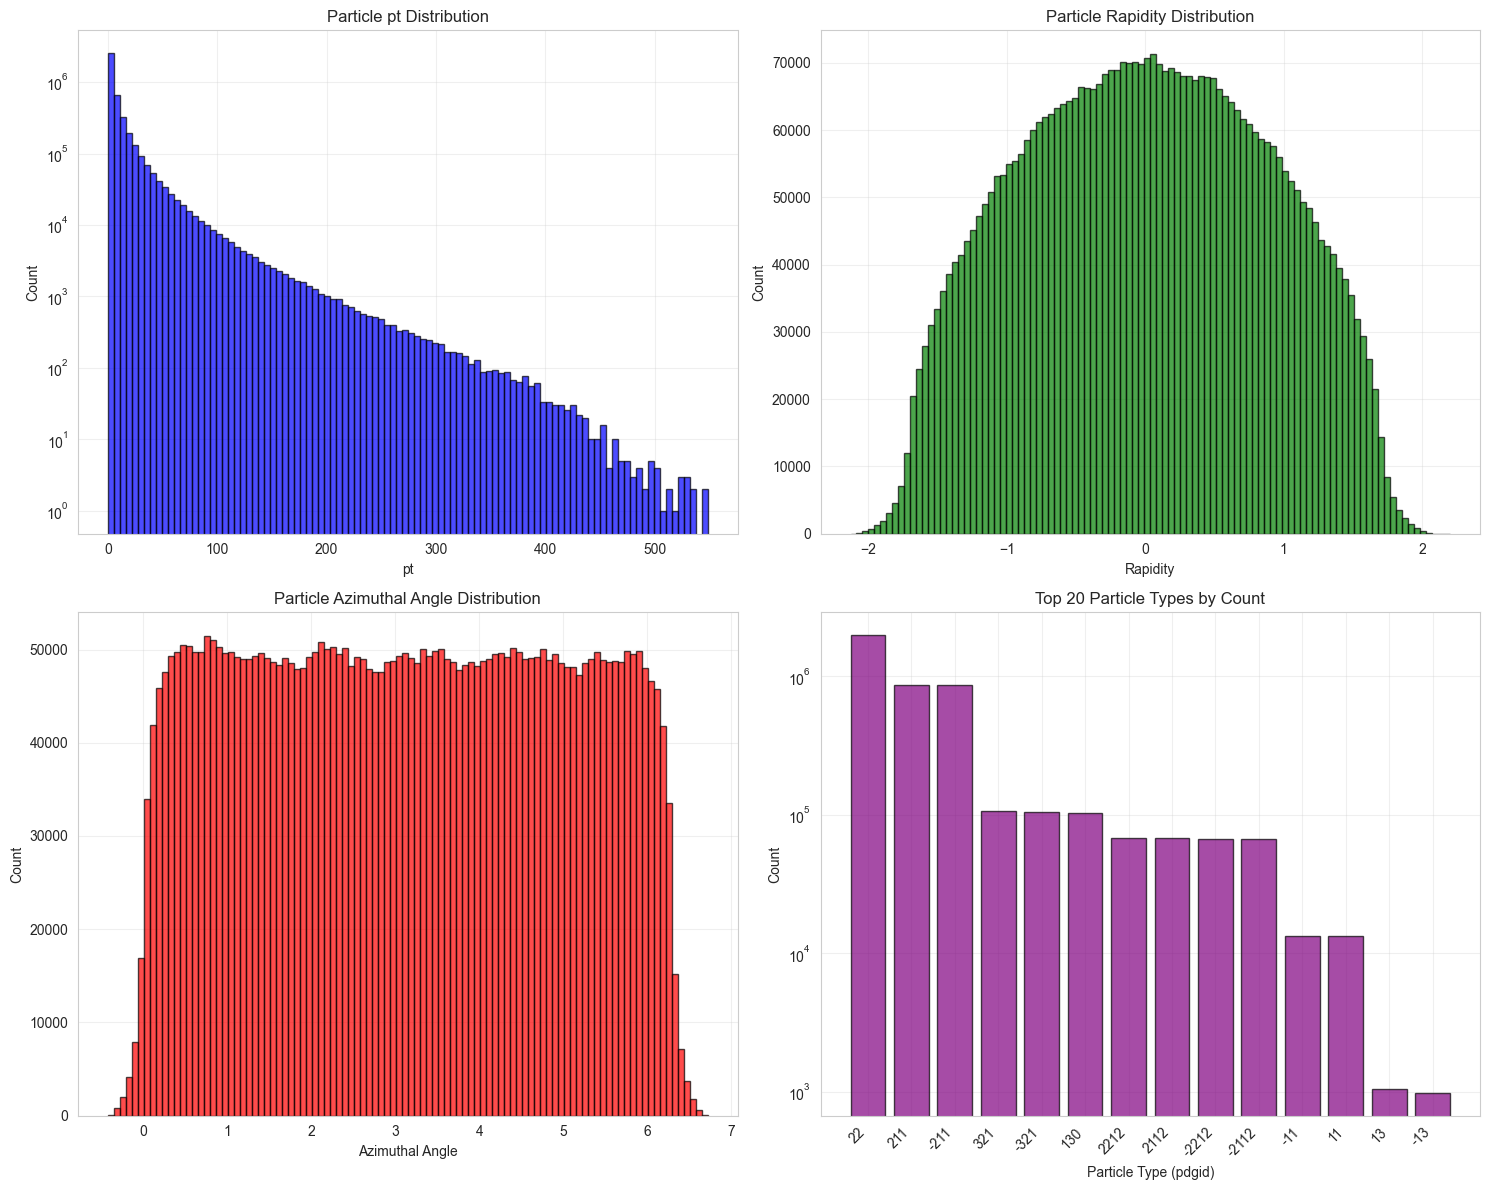

In [8]:
# Plot feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# pt distribution
axes[0, 0].hist(pt_all, bins=100, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_xlabel('pt')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Particle pt Distribution')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Rapidity distribution
axes[0, 1].hist(rapidity_all, bins=100, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Rapidity')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Particle Rapidity Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Azimuthal angle distribution
axes[1, 0].hist(phi_all, bins=100, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_xlabel('Azimuthal Angle')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Particle Azimuthal Angle Distribution')
axes[1, 0].grid(True, alpha=0.3)

# pdgid distribution (top 20)
unique, counts = np.unique(pdgid_all, return_counts=True)
top_indices = np.argsort(counts)[-20:][::-1]
axes[1, 1].bar(range(len(top_indices)), counts[top_indices], alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Particle Type (pdgid)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Top 20 Particle Types by Count')
axes[1, 1].set_xticks(range(len(top_indices)))
axes[1, 1].set_xticklabels([int(unique[i]) for i in top_indices], rotation=45, ha='right')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Compare Features Between Quark and Gluon Jets

Examine differences in particle features between jet types.

In [9]:
# Separate features by jet type
mask_quark = (X[:, :, 0] > 0) & (y[:, None] == 1)
mask_gluon = (X[:, :, 0] > 0) & (y[:, None] == 0)

pt_quark = X[:, :, 0][mask_quark]
pt_gluon = X[:, :, 0][mask_gluon]

rapidity_quark = X[:, :, 1][mask_quark]
rapidity_gluon = X[:, :, 1][mask_gluon]

phi_quark = X[:, :, 2][mask_quark]
phi_gluon = X[:, :, 2][mask_gluon]

print("Feature comparison:")
print(f"\npt:")
print(f"  Quark: {np.mean(pt_quark):.4f} ± {np.std(pt_quark):.4f}")
print(f"  Gluon: {np.mean(pt_gluon):.4f} ± {np.std(pt_gluon):.4f}")

print(f"\nRapidity:")
print(f"  Quark: {np.mean(rapidity_quark):.4f} ± {np.std(rapidity_quark):.4f}")
print(f"  Gluon: {np.mean(rapidity_gluon):.4f} ± {np.std(rapidity_gluon):.4f}")

print(f"\nAzimuthal angle:")
print(f"  Quark: {np.mean(phi_quark):.4f} ± {np.std(phi_quark):.4f}")
print(f"  Gluon: {np.mean(phi_gluon):.4f} ± {np.std(phi_gluon):.4f}")

Feature comparison:

pt:
  Quark: 15.6776 ± 32.5746
  Gluon: 9.8479 ± 17.7509

Rapidity:
  Quark: -0.0008 ± 0.8600
  Gluon: 0.0049 ± 0.8891

Azimuthal angle:
  Quark: 3.1302 ± 1.8209
  Gluon: 3.1420 ± 1.8207


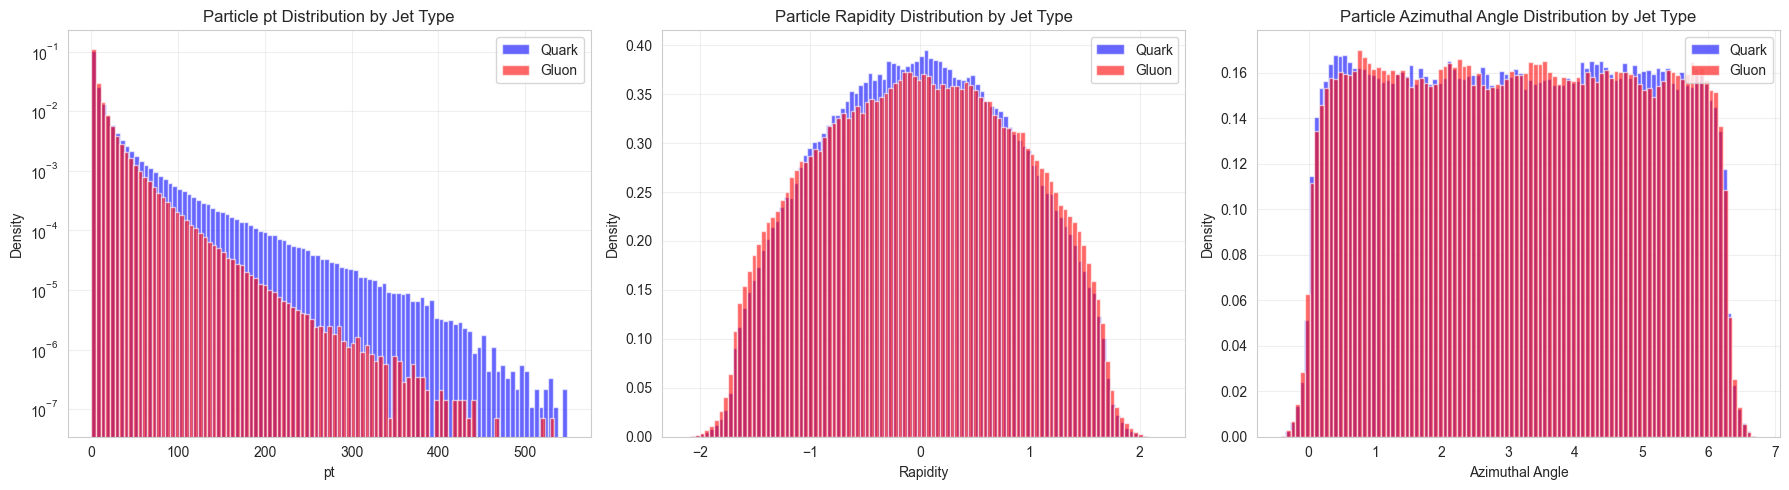

In [10]:
# Plot feature comparisons
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# pt comparison
axes[0].hist(pt_quark, bins=100, alpha=0.6, label='Quark', density=True, color='blue')
axes[0].hist(pt_gluon, bins=100, alpha=0.6, label='Gluon', density=True, color='red')
axes[0].set_xlabel('pt')
axes[0].set_ylabel('Density')
axes[0].set_title('Particle pt Distribution by Jet Type')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rapidity comparison
axes[1].hist(rapidity_quark, bins=100, alpha=0.6, label='Quark', density=True, color='blue')
axes[1].hist(rapidity_gluon, bins=100, alpha=0.6, label='Gluon', density=True, color='red')
axes[1].set_xlabel('Rapidity')
axes[1].set_ylabel('Density')
axes[1].set_title('Particle Rapidity Distribution by Jet Type')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Phi comparison
axes[2].hist(phi_quark, bins=100, alpha=0.6, label='Quark', density=True, color='blue')
axes[2].hist(phi_gluon, bins=100, alpha=0.6, label='Gluon', density=True, color='red')
axes[2].set_xlabel('Azimuthal Angle')
axes[2].set_ylabel('Density')
axes[2].set_title('Particle Azimuthal Angle Distribution by Jet Type')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Examine Sample Jets

Visualize a few example jets to understand the data structure.

In [11]:
# Examine a few sample jets
sample_quark_idx = np.where(y == 1)[0][0]
sample_gluon_idx = np.where(y == 0)[0][0]

print("Sample Quark Jet:")
print(f"  Index: {sample_quark_idx}")
print(f"  Label: {y[sample_quark_idx]}")
print(f"  Multiplicity: {multiplicity[sample_quark_idx]}")
print(f"\n  First 10 particles (pt, rapidity, phi, pdgid):")
for i in range(min(10, multiplicity[sample_quark_idx])):
    pt, rap, phi, pdg = X[sample_quark_idx, i]
    print(f"    Particle {i+1}: pt={pt:.4f}, rap={rap:.4f}, phi={phi:.4f}, pdgid={int(pdg)}")

print("\n" + "="*70)
print("\nSample Gluon Jet:")
print(f"  Index: {sample_gluon_idx}")
print(f"  Label: {y[sample_gluon_idx]}")
print(f"  Multiplicity: {multiplicity[sample_gluon_idx]}")
print(f"\n  First 10 particles (pt, rapidity, phi, pdgid):")
for i in range(min(10, multiplicity[sample_gluon_idx])):
    pt, rap, phi, pdg = X[sample_gluon_idx, i]
    print(f"    Particle {i+1}: pt={pt:.4f}, rap={rap:.4f}, phi={phi:.4f}, pdgid={int(pdg)}")

Sample Quark Jet:
  Index: 0
  Label: 1.0
  Multiplicity: 18

  First 10 particles (pt, rapidity, phi, pdgid):
    Particle 1: pt=0.2688, rap=0.3569, phi=4.7414, pdgid=22
    Particle 2: pt=0.1601, rap=-0.2556, phi=4.5502, pdgid=22
    Particle 3: pt=1.1487, rap=-0.0624, phi=4.5039, pdgid=-211
    Particle 4: pt=4.1316, rap=0.1737, phi=4.7662, pdgid=-321
    Particle 5: pt=1.6960, rap=-0.2122, phi=4.7969, pdgid=-211
    Particle 6: pt=2.1937, rap=-0.0525, phi=4.5756, pdgid=22
    Particle 7: pt=1.6191, rap=-0.0676, phi=4.6456, pdgid=22
    Particle 8: pt=6.5921, rap=0.0443, phi=4.7660, pdgid=211
    Particle 9: pt=3.7710, rap=0.0422, phi=4.7547, pdgid=321
    Particle 10: pt=13.4816, rap=-0.0280, phi=4.7354, pdgid=-211


Sample Gluon Jet:
  Index: 5
  Label: 0.0
  Multiplicity: 63

  First 10 particles (pt, rapidity, phi, pdgid):
    Particle 1: pt=7.7025, rap=-0.8198, phi=5.7949, pdgid=321
    Particle 2: pt=0.2074, rap=-0.2598, phi=5.9608, pdgid=22
    Particle 3: pt=1.1428, rap=-0.3

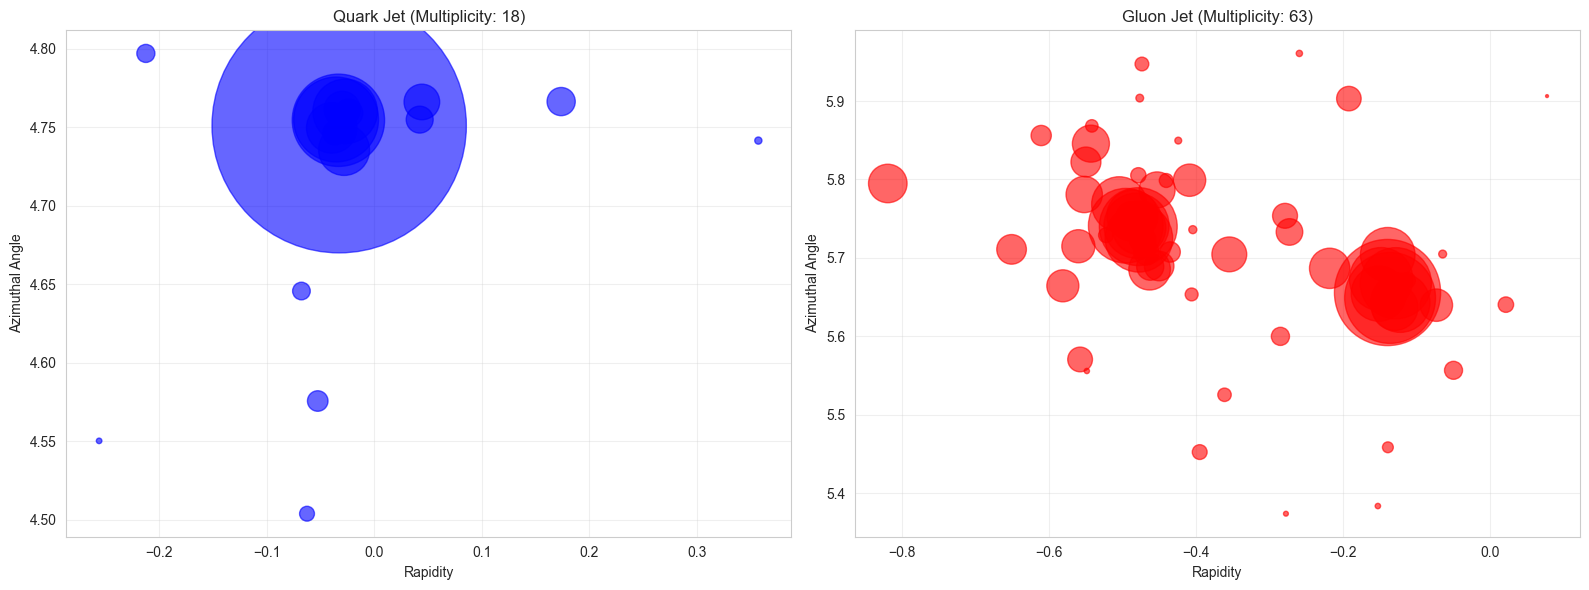

Note: Marker size represents particle pt


In [12]:
# Visualize jets in eta-phi plane
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Quark jet
jet_data = X[sample_quark_idx]
mask_jet = jet_data[:, 0] > 0
axes[0].scatter(jet_data[mask_jet, 1], jet_data[mask_jet, 2], 
               s=jet_data[mask_jet, 0]*100, alpha=0.6, c='blue')
axes[0].set_xlabel('Rapidity')
axes[0].set_ylabel('Azimuthal Angle')
axes[0].set_title(f'Quark Jet (Multiplicity: {multiplicity[sample_quark_idx]})')
axes[0].grid(True, alpha=0.3)

# Gluon jet
jet_data = X[sample_gluon_idx]
mask_jet = jet_data[:, 0] > 0
axes[1].scatter(jet_data[mask_jet, 1], jet_data[mask_jet, 2], 
               s=jet_data[mask_jet, 0]*100, alpha=0.6, c='red')
axes[1].set_xlabel('Rapidity')
axes[1].set_ylabel('Azimuthal Angle')
axes[1].set_title(f'Gluon Jet (Multiplicity: {multiplicity[sample_gluon_idx]})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Marker size represents particle pt")

## 7. Summary

Key findings from the exploratory data analysis:

In [13]:
print("="*70)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("="*70)

print(f"\n📊 Dataset Overview:")
print(f"  • Total jets: {len(y):,}")
print(f"  • Quark jets: {np.sum(y == 1):,} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"  • Gluon jets: {np.sum(y == 0):,} ({np.sum(y == 0)/len(y)*100:.1f}%)")
print(f"  • Max particles per jet: {X.shape[1]}")
print(f"  • Features per particle: {X.shape[2]} (pt, rapidity, phi, pdgid)")

print(f"\n🔢 Multiplicity Analysis:")
print(f"  • Overall mean: {np.mean(multiplicity):.2f} ± {np.std(multiplicity):.2f}")
print(f"  • Quark jets: {np.mean(mult_quark):.2f} ± {np.std(mult_quark):.2f}")
print(f"  • Gluon jets: {np.mean(mult_gluon):.2f} ± {np.std(mult_gluon):.2f}")
print(f"  • Key finding: Gluon jets have ~{(np.mean(mult_gluon)/np.mean(mult_quark)-1)*100:.1f}% more particles on average")

print(f"\n⚛️ Particle Features:")
print(f"  • Total non-padded particles: {len(pt_all):,}")
print(f"  • pt range: [{np.min(pt_all):.4f}, {np.max(pt_all):.4f}]")
print(f"  • Rapidity range: [{np.min(rapidity_all):.4f}, {np.max(rapidity_all):.4f}]")
print(f"  • Phi range: [{np.min(phi_all):.4f}, {np.max(phi_all):.4f}]")
print(f"  • Unique particle types (pdgid): {len(np.unique(pdgid_all))}")

print(f"\n✅ Data Quality:")
print(f"  • Balanced classes: {'Yes' if abs(np.sum(y == 1) - np.sum(y == 0)) < 100 else 'No'}")
print(f"  • Contains padding: Yes (zero pt particles)")
print(f"  • Data format: Compressed NumPy (.npz)")

print("\n" + "="*70)

EXPLORATORY DATA ANALYSIS SUMMARY

📊 Dataset Overview:
  • Total jets: 100,000
  • Quark jets: 50,000 (50.0%)
  • Gluon jets: 50,000 (50.0%)
  • Max particles per jet: 139
  • Features per particle: 4 (pt, rapidity, phi, pdgid)

🔢 Multiplicity Analysis:
  • Overall mean: 43.31 ± 17.65
  • Quark jets: 33.40 ± 13.34
  • Gluon jets: 53.22 ± 15.76
  • Key finding: Gluon jets have ~59.3% more particles on average

⚛️ Particle Features:
  • Total non-padded particles: 4,330,905
  • pt range: [0.0001, 548.4937]
  • Rapidity range: [-2.1281, 2.2004]
  • Phi range: [-0.4199, 6.7172]
  • Unique particle types (pdgid): 14

✅ Data Quality:
  • Balanced classes: Yes
  • Contains padding: Yes (zero pt particles)
  • Data format: Compressed NumPy (.npz)



## 8. Comprehensive Dataset Statistics for Classifier Training

In [16]:
# Comprehensive statistics for classifier training
import json

stats = {
    "dataset": {
        "total_samples": int(len(y)),
        "n_quark_jets": int(np.sum(y == 1)),
        "n_gluon_jets": int(np.sum(y == 0)),
        "class_balance": float(np.sum(y == 1) / len(y)),
    },
    "shape": {
        "X_shape": list(X.shape),
        "y_shape": list(y.shape),
        "max_particles_per_jet": int(X.shape[1]),
        "features_per_particle": int(X.shape[2]),
        "feature_names": ["pt", "rapidity", "azimuthal_angle", "pdgid"],
    },
    "padding": {
        "is_zero_padded": True,
        "padding_criterion": "pt == 0",
        "avg_padding_per_jet": float(X.shape[1] - np.mean(multiplicity)),
    },
    "multiplicity": {
        "overall": {
            "mean": float(np.mean(multiplicity)),
            "std": float(np.std(multiplicity)),
            "min": int(np.min(multiplicity)),
            "max": int(np.max(multiplicity)),
            "median": float(np.median(multiplicity)),
            "percentile_25": float(np.percentile(multiplicity, 25)),
            "percentile_75": float(np.percentile(multiplicity, 75)),
        },
        "quark": {
            "mean": float(np.mean(mult_quark)),
            "std": float(np.std(mult_quark)),
        },
        "gluon": {
            "mean": float(np.mean(mult_gluon)),
            "std": float(np.std(mult_gluon)),
        },
        "ratio_gluon_to_quark": float(np.mean(mult_gluon) / np.mean(mult_quark)),
    },
    "features": {
        "pt": {
            "min": float(np.min(pt_all)),
            "max": float(np.max(pt_all)),
            "mean": float(np.mean(pt_all)),
            "std": float(np.std(pt_all)),
        },
        "rapidity": {
            "min": float(np.min(rapidity_all)),
            "max": float(np.max(rapidity_all)),
            "mean": float(np.mean(rapidity_all)),
            "std": float(np.std(rapidity_all)),
        },
        "azimuthal_angle": {
            "min": float(np.min(phi_all)),
            "max": float(np.max(phi_all)),
            "mean": float(np.mean(phi_all)),
            "std": float(np.std(phi_all)),
        },
        "pdgid": {
            "n_unique": int(len(np.unique(pdgid_all))),
            "total_particles": int(len(pdgid_all)),
        },
    },
    "file": {
        "path": "data/qg_jets.npz",
        "size_mb": float(data_path.stat().st_size / (1024**2)),
    }
}

# Print formatted statistics
print("="*70)
print("DATASET STATISTICS FOR CLASSIFIER TRAINING")
print("="*70)

print("\n📁 Dataset Overview:")
print(f"  Total samples: {stats['dataset']['total_samples']:,}")
print(f"  Quark jets: {stats['dataset']['n_quark_jets']:,} ({stats['dataset']['class_balance']*100:.1f}%)")
print(f"  Gluon jets: {stats['dataset']['n_gluon_jets']:,} ({(1-stats['dataset']['class_balance'])*100:.1f}%)")

print("\n📐 Data Shape:")
print(f"  X: {tuple(stats['shape']['X_shape'])} (n_samples, max_particles, n_features)")
print(f"  y: {tuple(stats['shape']['y_shape'])} (binary labels: 0=gluon, 1=quark)")

print("\n🔢 Multiplicity (particles per jet):")
print(f"  Overall: {stats['multiplicity']['overall']['mean']:.1f} ± {stats['multiplicity']['overall']['std']:.1f}")
print(f"  Quark:   {stats['multiplicity']['quark']['mean']:.1f} ± {stats['multiplicity']['quark']['std']:.1f}")
print(f"  Gluon:   {stats['multiplicity']['gluon']['mean']:.1f} ± {stats['multiplicity']['gluon']['std']:.1f}")
print(f"  Gluon/Quark ratio: {stats['multiplicity']['ratio_gluon_to_quark']:.3f} (KEY DISCRIMINATOR)")

print("\n🔍 Feature Ranges:")
for feat in ["pt", "rapidity", "azimuthal_angle"]:
    print(f"  {feat:16s}: [{stats['features'][feat]['min']:.4f}, {stats['features'][feat]['max']:.4f}]")
print(f"  {'pdgid':16s}: {stats['features']['pdgid']['n_unique']} unique particle types")

print("\n⚙️ Padding Info:")
print(f"  Zero-padded: {stats['padding']['is_zero_padded']}")
print(f"  Avg padding: {stats['padding']['avg_padding_per_jet']:.1f} particles per jet")
print(f"  Max particles: {stats['shape']['max_particles_per_jet']}")

print("\n" + "="*70)

# Store for later use
dataset_stats = stats

DATASET STATISTICS FOR CLASSIFIER TRAINING

📁 Dataset Overview:
  Total samples: 100,000
  Quark jets: 50,000 (50.0%)
  Gluon jets: 50,000 (50.0%)

📐 Data Shape:
  X: (100000, 139, 4) (n_samples, max_particles, n_features)
  y: (100000,) (binary labels: 0=gluon, 1=quark)

🔢 Multiplicity (particles per jet):
  Overall: 43.3 ± 17.6
  Quark:   33.4 ± 13.3
  Gluon:   53.2 ± 15.8
  Gluon/Quark ratio: 1.593 (KEY DISCRIMINATOR)

🔍 Feature Ranges:
  pt              : [0.0001, 548.4937]
  rapidity        : [-2.1281, 2.2004]
  azimuthal_angle : [-0.4199, 6.7172]
  pdgid           : 14 unique particle types

⚙️ Padding Info:
  Zero-padded: True
  Avg padding: 95.7 particles per jet
  Max particles: 139



---

## 📋 Quick Reference: Quark-Gluon Jet Dataset

**Task:** Binary classification of particle jets (quark vs. gluon) — a fundamental benchmark in collider physics.

### Loading the Data

```python
import numpy as np
from pathlib import Path

# Load dataset
data = np.load("data/qg_jets.npz")
X, y = data['X'], data['y']

# X: (100000, 139, 4) - jets with up to 139 particles, 4 features each
# y: (100000,) - binary labels (0=gluon, 1=quark)
```

### Dataset Summary

| Property | Value |
|----------|-------|
| **Total samples** | 100,000 (50k quark, 50k gluon) |
| **Class balance** | Perfectly balanced (50/50) |
| **Shape** | X: (100000, 139, 4), y: (100000,) |
| **Features per particle** | 4: [pt, rapidity, φ, pdgid] |
| **Zero-padded** | Yes (padding where pt=0) |

### Key Physics Insight

**Multiplicity is the primary discriminator:**
- Quark jets: **33.4 ± 13.3** particles/jet
- Gluon jets: **53.2 ± 15.8** particles/jet  
- **Gluon/Quark ratio: 1.59** — Gluons radiate more due to stronger QCD coupling

> **Why this matters:** Gluons have ~59% more particles than quarks on average. This is the fundamental physics signal that makes classification possible. Without this multiplicity difference, the task would be impossible!

### Feature Descriptions

| Feature | Description | Range | Use in Classifiers |
|---------|-------------|-------|-------------------|
| `pt` | Transverse momentum | [0.0001, 548.49] GeV | ✅ Realistic |
| `rapidity` | Pseudorapidity η | [-2.13, 2.20] | ✅ Realistic |
| `azimuthal_angle` | Azimuthal angle φ | [-0.42, 6.72] rad | ✅ Realistic |
| `pdgid` | Particle ID (MC truth) | 14 unique types | ⚠️ Not available in real detectors |

> **Note on `pdgid`:** This is Monte Carlo truth information. In realistic classifiers, **do not use pdgid** as a feature—real detectors cannot perfectly identify particle species. Use only kinematic features (pt, η, φ).

### Data Characteristics

- **Padding:** Average 95.7 padded particles per jet (out of max 139)
- **Real particles:** ~43 particles/jet on average (excluding padding)
- **Generator:** Pythia 8.226
- **Jet algorithm:** Anti-kt with R=0.4, pt ∈ [500, 550] GeV

### Baseline Expectations

For classifier development:
- **Random baseline:** 50% accuracy (AUC = 0.5)
- **Physics baseline:** Multiplicity-based logistic regression should reach AUC ~0.70-0.75
- **Strong baseline:** Particle-level ML models achieve AUC > 0.80

### Usage Notes

1. **Handle padding:** Filter particles with `pt > 0` or use masking
2. **Variable length:** Jets have different particle counts (min: 12, max: 107, median: 40)
3. **Balanced classes:** No need for class weighting
4. **Standard split:** Use stratified train/test split (e.g., 80/20)

### Next Steps for Classifier Training

1. Extract high-level features (e.g., jet multiplicity, pt distributions)
2. Or: Use raw particle clouds with deep learning (e.g., ParticleNet, Energy Flow Networks)
3. Or: Convert to text format for LLM-based zero-shot classification
4. Compare against simple logistic regression on multiplicity alone

---

*Dataset source: [EnergyFlow QG-Jets](https://energyflow.network/docs/datasets/#quark-and-gluon-jets)*